In [16]:
import librosa 
import numpy as np 
import os 
import matplotlib.pyplot as plt

In [17]:
#loading single audio 
audio_path1 = "./weapons audio/andrew1.wav"
y, sr = librosa.load(audio_path1, sr=None)
print("Audio shape:", y.shape)
print("Sample rate:", sr)

Audio shape: (378000,)
Sample rate: 44100


then, i pip installed tochaudio, sentence-transformers (MiniLM) like BERT but allegedly faster, then im using hugging face for wav2vec (so i can embed the wav files yay!)


In [18]:
#load models 
from sentence_transformers import SentenceTransformer
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
import torch

In [19]:
text_model = SentenceTransformer('all-MiniLM-L6-v2')
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
audio_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

c:\Users\Melissa Wang\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [20]:
import pickle
import soundfile as sf

audio_folder = "weapons audio"
save_folder = "saved_embeds"
save_path = os.path.join(save_folder, "conversation_embeddings.pkl")

if os.path.exists(save_path):
    with open(save_path, "rb") as f:
        embeddings_dict = pickle.load(f)
    print(f"Loaded embeddings from {save_path}")
else:
    audio_model.eval()
    os.makedirs(save_folder, exist_ok=True) #ensures if it exists

    speakers = ["andrew", "justine"]
    embeddings_dict = {speaker: [] for speaker in speakers}

    #helper function loads the wav file returns tensor waveform, just preps for wav2vec
    def load_audio(file_path):
        waveform, sample_rate = sf.read(file_path)  
        waveform = torch.tensor(waveform.T, dtype=torch.float32) 
        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0)
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        return waveform

    #helper function embeds one speaker. finds the speaker, sorts in chrono order
    def embed_speaker(speaker_name):
        speaker_files = sorted([f for f in os.listdir(audio_folder) if f.startswith(speaker_name)])
        speaker_embeddings = []

        for f in speaker_files:
            file_path = os.path.join(audio_folder, f)
            waveform = load_audio(file_path) #^above function to make sure it's ready 
            input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values 
            with torch.no_grad(): #no training, just embedding
                outputs = audio_model(input_values)
                embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu()
                speaker_embeddings.append(embedding)
        
        return speaker_embeddings 

    for speaker in speakers:
        print(f"Embedding {speaker}...")
        embeddings_dict[speaker] = embed_speaker(speaker)

    with open(save_path, "wb") as f:
        pickle.dump(embeddings_dict, f)

    print(f"Saved embeddings to {save_path}")

Loaded embeddings from saved_embeds\conversation_embeddings.pkl


In [21]:
import torch.nn.functional as F
save_folder = "saved_embeds"
os.makedirs(save_folder, exist_ok=True)

text_save_path = os.path.join(save_folder, "text_embeddings.pkl")
combined_save_path = os.path.join(save_folder, "combined_embeddings.pkl")

if os.path.exists(text_save_path):
    with open(text_save_path, "rb") as f:
        text_embeddings = pickle.load(f)
    print(f"Loaded text embeddings from {text_save_path}")
else:
    conversation_file = "weapons.txt"
    text_dict = {"andrew": [], "justine": []}
    with open(conversation_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.upper().startswith("ANDREW"):
            text_dict["andrew"].append(line[len("ANDREW"):].strip())
        elif line.upper().startswith("JUSTINE"):
            text_dict["justine"].append(line[len("JUSTINE"):].strip())
    

    text_embeddings = {}
    for speaker in text_dict:
        utterances = text_dict[speaker]
        embeddings = text_model.encode(utterances, convert_to_tensor=True)
        text_embeddings[speaker] = embeddings
    
    with open(text_save_path, "wb") as f:
        pickle.dump(text_embeddings, f)
    print(f"Saved text embeddings to {text_save_path}")


if os.path.exists(combined_save_path):
    with open(combined_save_path, "rb") as f:
        combined_embeddings = pickle.load(f)
    print(f"Loaded combined embeddings from {combined_save_path}")
else:
    combined_embeddings = {}

    for speaker in text_embeddings:
        combined_embeddings[speaker] = []

        for audio_emb, text_emb in zip(embeddings_dict[speaker],text_embeddings[speaker]):
            audio_norm = F.normalize(audio_emb, dim=0)
            text_norm = F.normalize(text_emb, dim=0)

            combined = torch.cat([audio_norm, text_norm])
            combined_embeddings[speaker].append(combined)

    with open(combined_save_path, "wb") as f:
        pickle.dump(combined_embeddings, f)

    print(f"Saved normalized combined embeddings to {combined_save_path}")

Loaded text embeddings from saved_embeds\text_embeddings.pkl
Saved normalized combined embeddings to saved_embeds\combined_embeddings.pkl


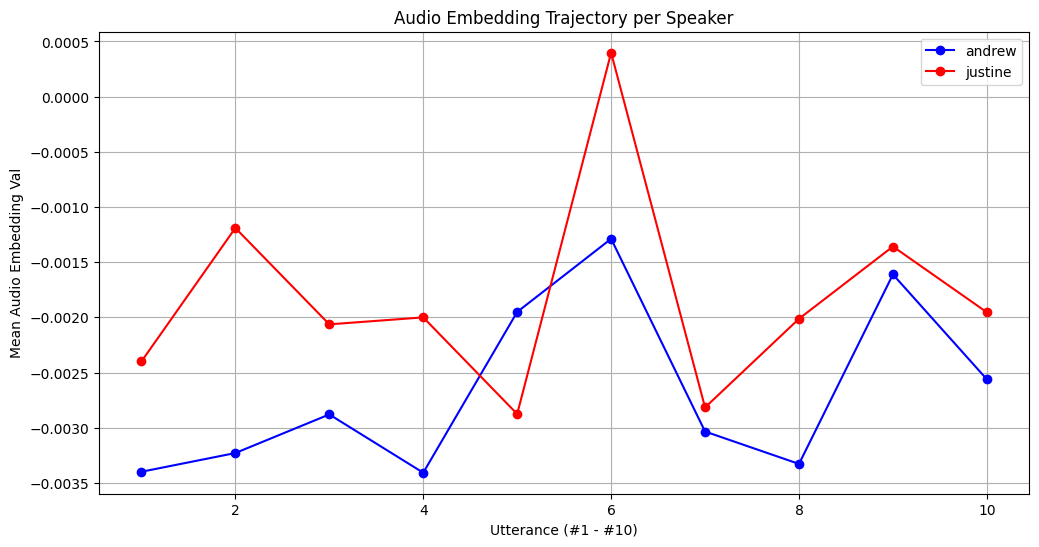

In [22]:
#so embeddings_dict rn should look like = {andrew: [torch tensors], justine: [..]}
#now we plot 1. just the emotional trajectory of each person's audio by themself 

import matplotlib.pyplot as plt
import torch

def plot_2d_traj(embeddings_dict, title="Audio Embedding Trajectory per Speaker"):
    plt.figure(figsize=(12,6))
    
    colors = {"andrew": "blue", "justine": "red"}
    
    for speaker in embeddings_dict:
        speaker_embeddings = torch.stack(embeddings_dict[speaker]) #combines list into 2d tensors
        mean_vals = speaker_embeddings.mean(dim=1).numpy() #takes mean across the embedding dimensions for each utterance 1d array 
        plt.plot(range(1, len(mean_vals)+1), mean_vals, marker='o', label=speaker, color=colors[speaker])
    
    plt.xlabel("Utterance (#1 - #10)")
    plt.ylabel("Mean Audio Embedding Val")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_2d_traj(embeddings_dict)



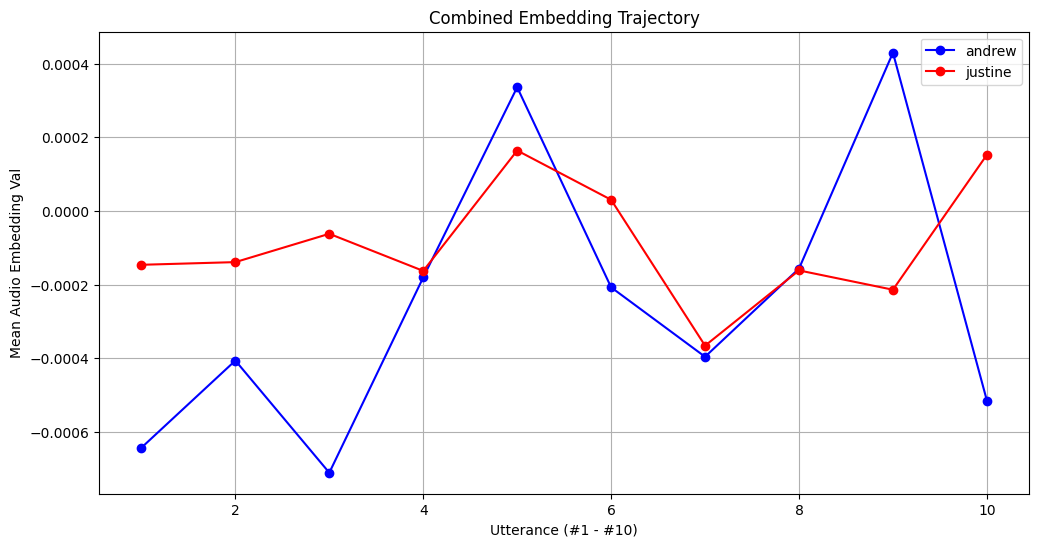

In [23]:
#now the combiend (with text) 2d line plot of mean vals, not anything crazy doesn't rly tell us much just trying to see what our data looks like
plot_2d_traj(combined_embeddings, title="Combined Embedding Trajectory")

Ok so ofc. This mean value reduces each vector into a single scalar so this is really rough. But, this is very interesting. In this scene of the beginning of the horror movie Weapons, the teacher Justine is having a talk with the principal Andrew. The premise of the story is that all the kids suddenly dissapear from just Justine's class except one kid, Alex Lilly. Thus, this conversation is kind of "heated" because while Justine is innocent, all the parents believe she must be related because she's the authority figure in this mysterious situation. Andrew doesn't explicitly fire her but basically tells her she can't come to work or talk to Alex. 

At around the 4th utterance, Justine asks if she can speak with Alex. Then, there's a lot of nuance in what is implied in the next sentences in terms of emotion. All I can say for my subjective feeling is that, I feel as if both sides are subtly implying digs. Andrew subtly possibly implies Justine is being self-centered by saying in this situation we need to focus on Alex. Justine possibly picks up on this (again this is now my interpretation of the scene) and says on the 6th utterance "If you are implying that I don't care about Alex..." which directly answers what could be implied rather than what was said => very heated. That sudden spike COULD be related. veryyy interesting!!!! 

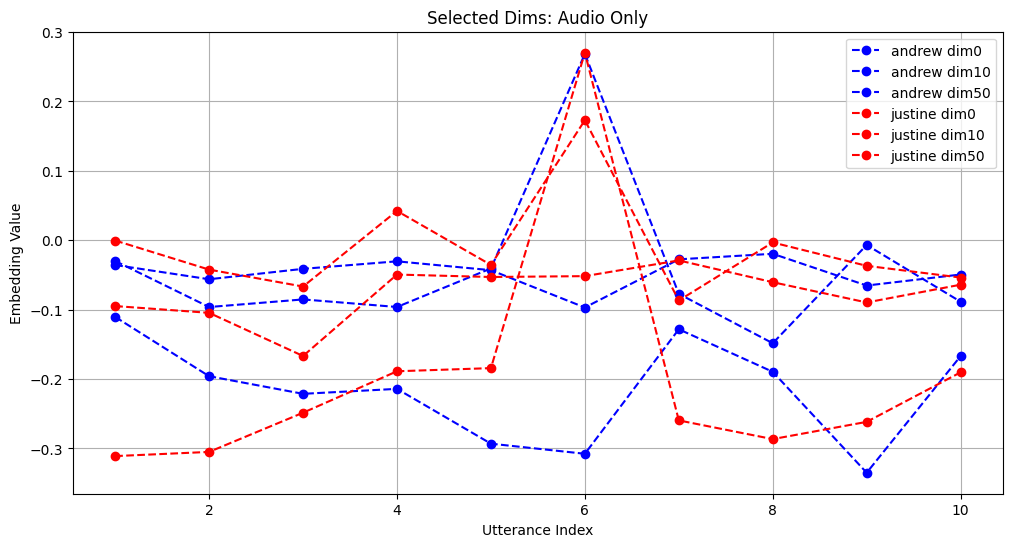

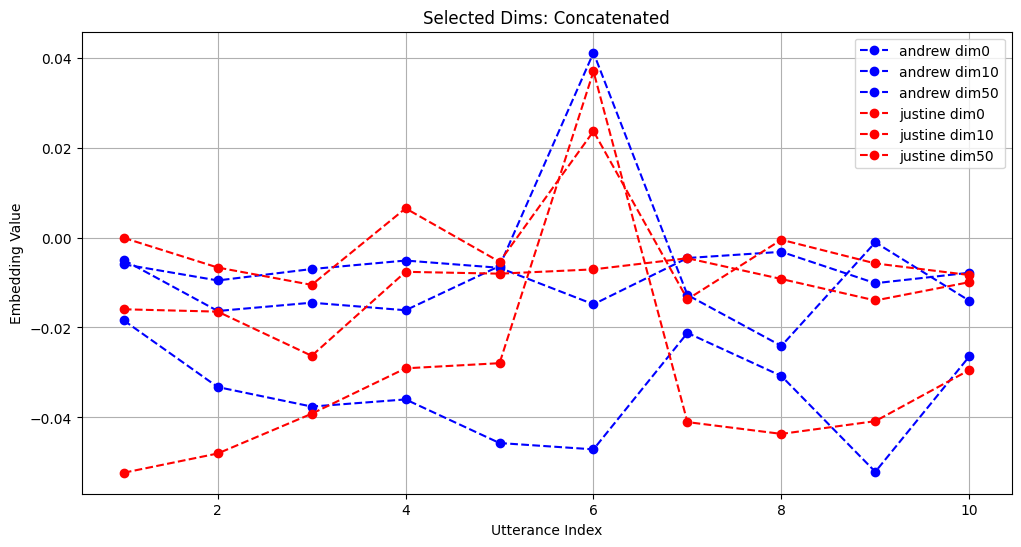

In [ ]:
#roughly seeing what dimensions are contributing to the
def plot_selected_dims(embeddings_dict, dims=[0, 10, 50], title="Selected Embedding Dimensions"):
    plt.figure(figsize=(12,6))
    colors = {"andrew": "blue", "justine": "red"}
    
    for speaker in embeddings_dict:
        speaker_embeddings = torch.stack(embeddings_dict[speaker])
        for dim in dims:
            plt.plot(range(1, len(speaker_embeddings)+1), speaker_embeddings[:, dim].numpy(),
                     marker='o', linestyle='--', label=f"{speaker} dim{dim}", color=colors[speaker])
    
    plt.xlabel("Utterance Index")
    plt.ylabel("Embedding Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_selected_dims(embeddings_dict, title="Selected Dims: Audio Only")
plot_selected_dims(combined_embeddings, title="Selected Dims: Concatenated")


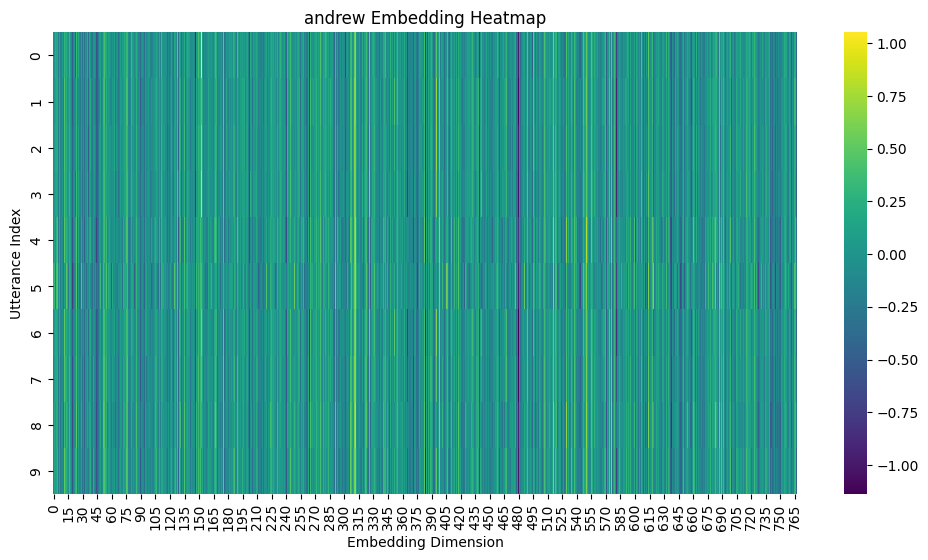

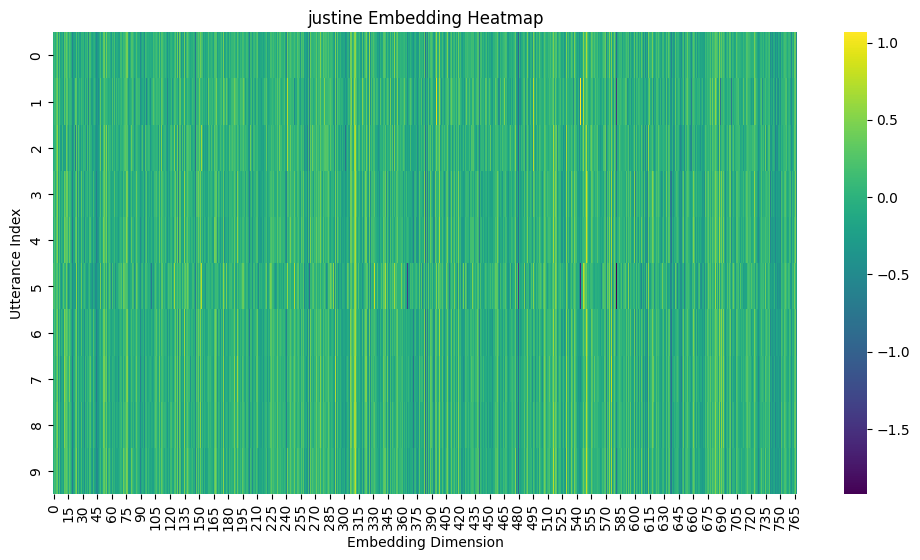

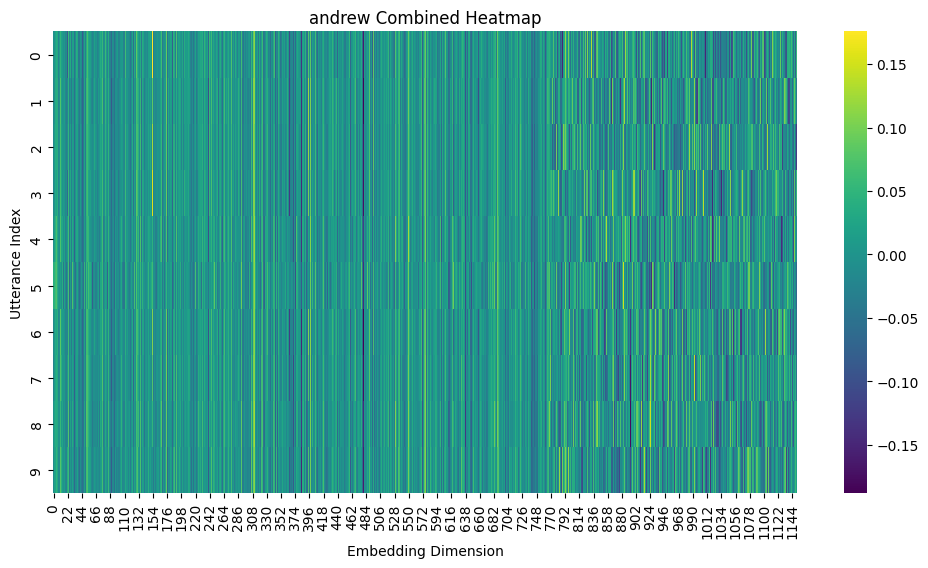

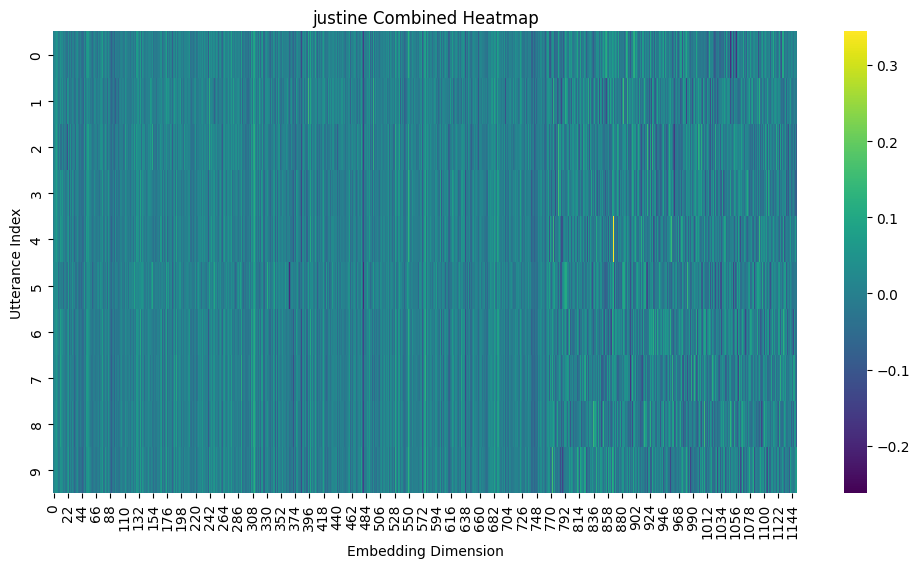

In [25]:
#gauging which dimensions seem to be contributing to that spike
import seaborn as sns 
def plot_embedding_heatmap(embeddings_dict, speaker, title="Embedding Heatmap"):
    speaker_embeddings = torch.stack(embeddings_dict[speaker]).numpy()
    plt.figure(figsize=(12,6))
    sns.heatmap(speaker_embeddings, cmap="viridis")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Utterance Index")
    plt.title(f"{speaker} {title}")
    plt.show()

plot_embedding_heatmap(embeddings_dict, "andrew")
plot_embedding_heatmap(embeddings_dict, "justine")
plot_embedding_heatmap(combined_embeddings, "andrew", title="Combined Heatmap")
plot_embedding_heatmap(combined_embeddings, "justine", title="Combined Heatmap")

In [28]:
#normalized audio 
audio_embeddings_norm = {
    speaker: [F.normalize(e, dim=0) for e in embs]
    for speaker, embs in embeddings_dict.items()
}

with open("saved_embeds/audio_embeddings_norm.pkl", "wb") as f:
    pickle.dump(audio_embeddings_norm, f)

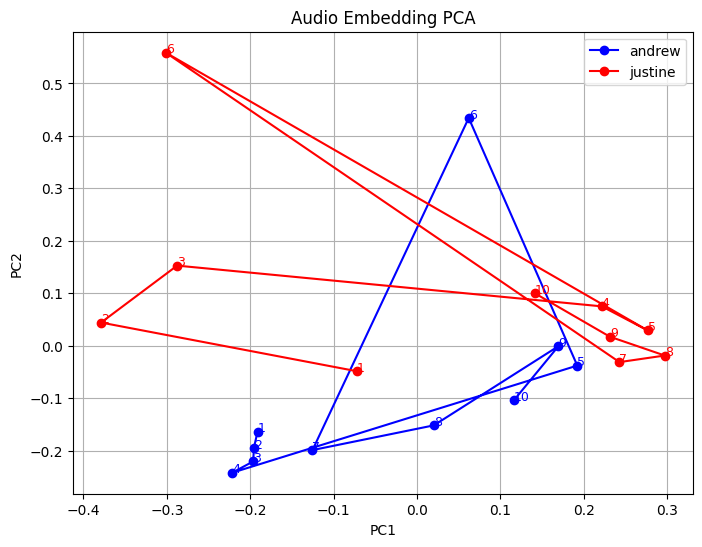

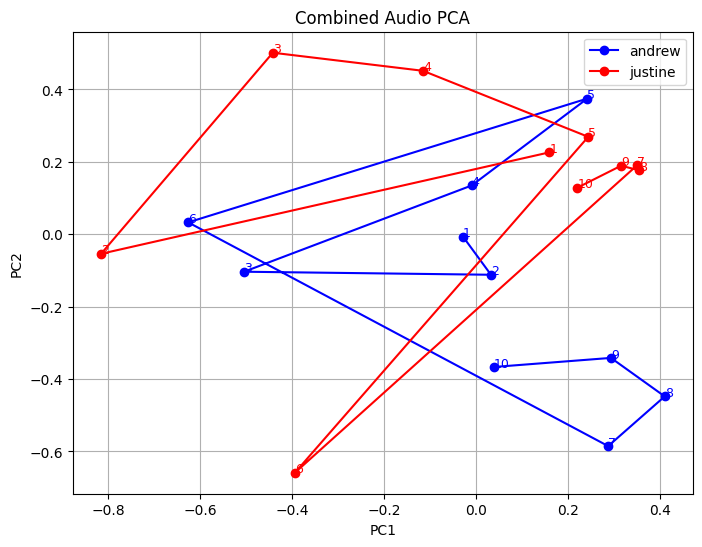

In [33]:
#pca plotting 
from sklearn.decomposition import PCA

def pca_plot_embeddings(embeddings, n_components=2, title="PCA Trajectory"):
    all_embs = []
    speakers = []

    for speaker in embeddings:
        for emb in embeddings[speaker]:
            all_embs.append(emb.numpy())
            speakers.append(speaker)

    X = np.vstack(all_embs)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8,6))
    colors = {"andrew": "blue", "justine": "red"}

    idx = 0
    for speaker in embeddings:
        speaker_len = len(embeddings[speaker])
        speaker_points = X_pca[idx:idx+speaker_len]
        plt.plot(
            speaker_points[:,0],
            speaker_points[:,1],
            marker="o",
            color=colors[speaker],
            label=speaker
        )

        for i, (x, y) in enumerate(speaker_points):
            plt.text(x, y, str(i+1), fontsize=9, color=colors[speaker])

        idx += speaker_len

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return X_pca, pca


X_pca_audio, pca_audio = pca_plot_embeddings(audio_embeddings_norm,title="Audio Embedding PCA")
X_pca_combined, pca_combined = pca_plot_embeddings(combined_embeddings, title="Combined Audio PCA")

In [30]:
print("Audio PCA variance:", pca_audio.explained_variance_ratio_[:5])
print("Combined PCA variance:", pca_combined.explained_variance_ratio_[:5])

Audio PCA variance: [0.28839016 0.24579962]
Combined PCA variance: [0.13253431 0.10968187]


^ For the Audio only: first 2 principal components explain about 53% total variance. Versus for the Combined embeddings, the first 2 principal components only explain about 24% variance. 

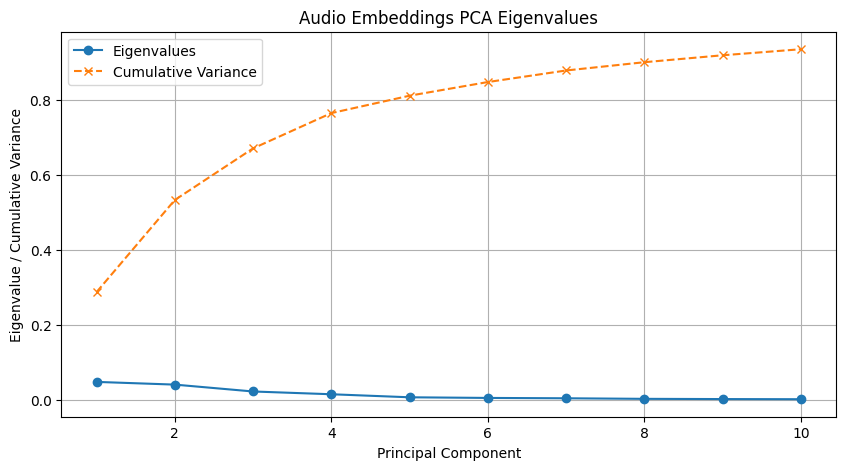

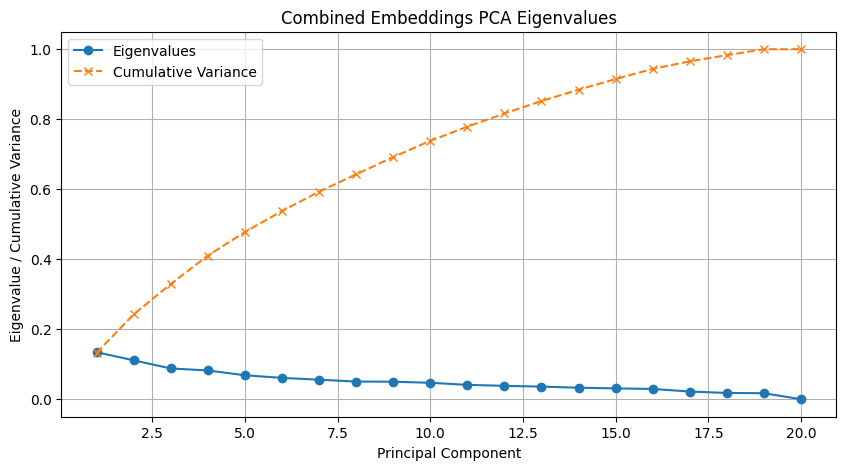

In [35]:
#plot eigenvalues 
def plot_eigenvalues(embeddings_dict, n_components=20, title="Eigenvalues of PCA"):
    all_embs = []
    for speaker in embeddings_dict:
        for emb in embeddings_dict[speaker]:
            all_embs.append(emb.numpy())
    X = np.vstack(all_embs)

    if n_components is None:
        n_components = min(X.shape)
    
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    eigenvalues = pca.explained_variance_
    variance_exp = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', label='Eigenvalues')
    plt.plot(range(1, len(eigenvalues)+1), variance_exp, marker='x', linestyle='--', label='Cumulative Variance')
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue / Cumulative Variance")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

    return eigenvalues, variance_exp, pca


eigs_audio, audio_exp, pca_audio = plot_eigenvalues(audio_embeddings_norm, n_components=10, title="Audio Embeddings PCA Eigenvalues")

eigs_combined, combined_exp, pca_combined = plot_eigenvalues(combined_embeddings, n_components=20, title="Combined Embeddings PCA Eigenvalues")



hmmm all the eigenvalues approx same.. probably bc very little principal components available anyways and 700 something dimensions for audio and 700 for text.. 

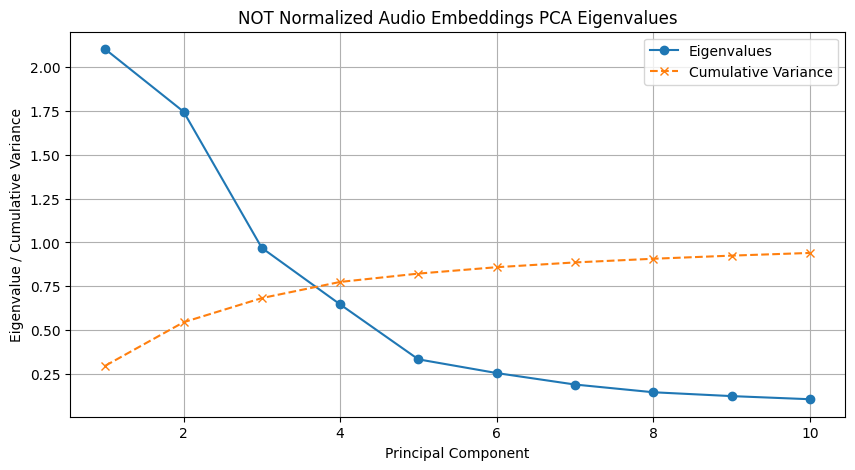

In [36]:
eigs_audio2, audio_exp2, pca_audio2 = plot_eigenvalues(embeddings_dict, n_components=10, title="NOT Normalized Audio Embeddings PCA Eigenvalues")